In [6]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2899968/45929032 bytes (6.3%)6692864/45929032 bytes (14.6%)10428416/45929032 bytes (22.7%)14229504/45929032 bytes (31.0%)17874944/45929032 bytes (38.9%)21831680/45929032 bytes (47.5%)25649152/45929032 bytes (55.8%)29548544/45929032 bytes (64.3%)33587200/45929032 bytes (73.1%)37412864/45929032 bytes (81.5%)41435136/45929032 bytes (90.2%)45490176/45929032 bytes (99.0%)

In [7]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

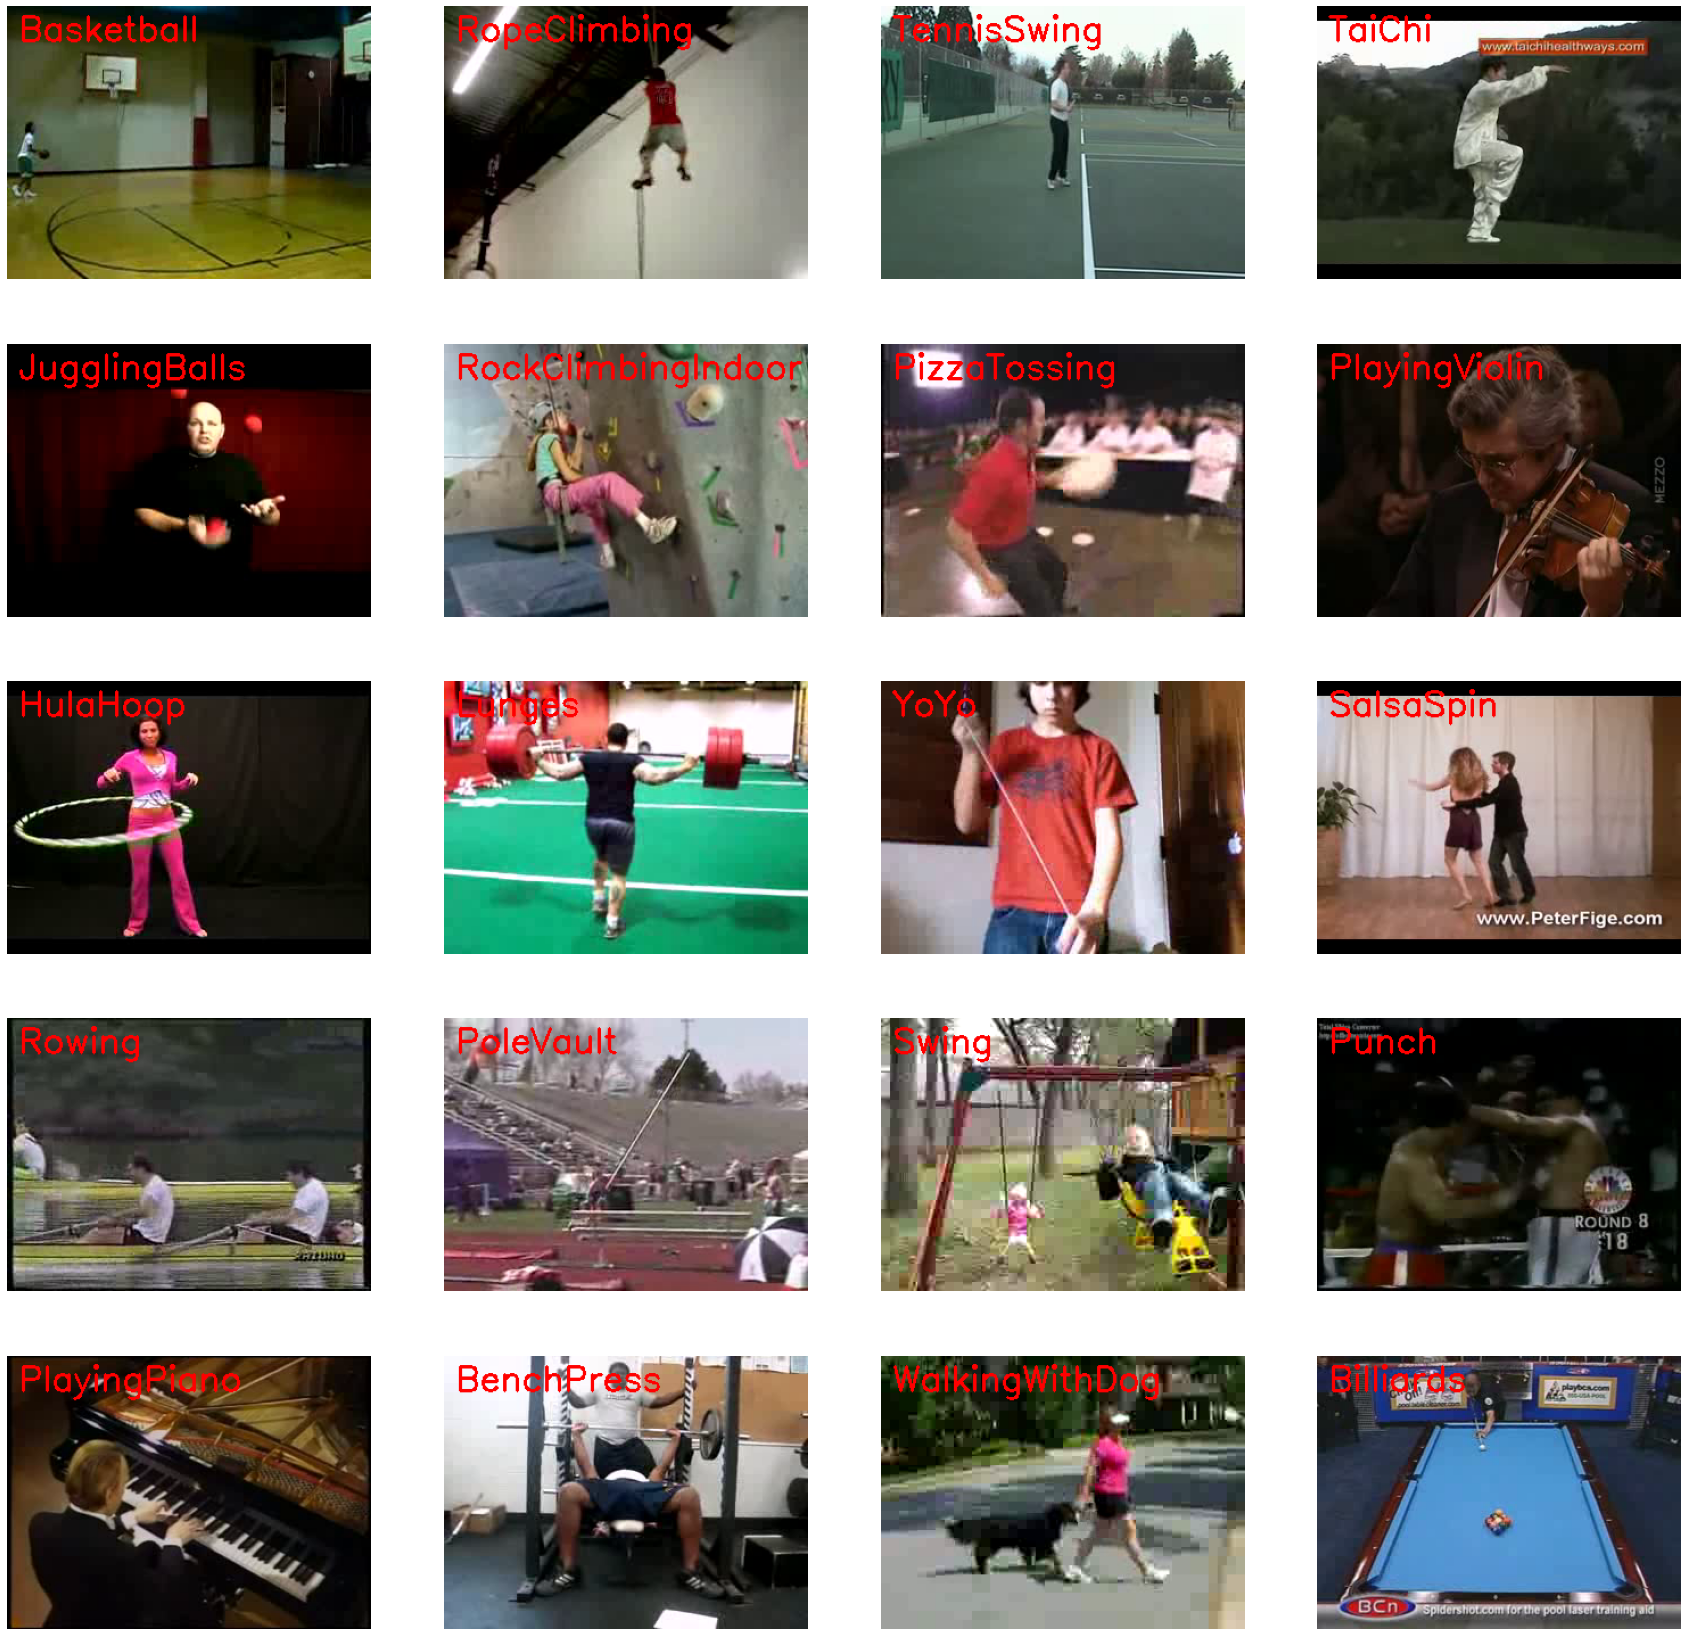

In [8]:
plt.figure(figsize = (30, 30))

all_classes_names = os.listdir('drive/My Drive/UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    
    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'drive/My Drive/UCF50/{selected_class_Name}')
    
    selected_video_file_name = random.choice(video_files_names_list)
    
    video_reader = cv2.VideoCapture(f'drive/My Drive/UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    _, bgr_frame = video_reader.read()
    
    video_reader.release()
    
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    cv2.putText(rgb_frame, selected_class_Name, (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    plt.subplot(5, 4, counter)
    
    plt.imshow(rgb_frame)
    
    plt.axis('off')

In [9]:
image_height, image_width = 64, 64
max_images_per_class = 8000
dataset_directory = "drive/My Drive/UCF50"
classes_list = ["WalkingWithDog","TaiChi", "Swing", "HorseRace"]
model_output_size = len(classes_list)

In [10]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    while True:
        success, frame = video_reader.read()
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
        
    
    video_reader.release()
    
    return frames_list
    

In [11]:
def create_dataset():
    temp_features = []
    features = []
    labels = []
    
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            
            frames = frames_extraction(video_file_path)
            
            temp_features.extend(frames)
            
        features.extend(random.sample(temp_features, max_images_per_class))
        
        labels.extend([class_index] * max_images_per_class)
        
        temp_features.clear()
        
    features = np.asarray(features)
    
    labels = np.array(labels)
    
    return features, labels

In [12]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [15]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu',input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
    model.summary()
    
    return model

model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [16]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 53s 5ms/step - loss: 0.8841 - accuracy: 0.6401 - val_loss: 0.5007 - val_accuracy: 0.7992
Epoch 2/50
5120/5120 [==============================] - 23s 4ms/step - loss: 0.5077 - accuracy: 0.8148 - val_loss: 0.2481 - val_accuracy: 0.9170
Epoch 3/50
5120/5120 [==============================] - 23s 5ms/step - loss: 0.3673 - accuracy: 0.8690 - val_loss: 0.2941 - val_accuracy: 0.9215
Epoch 4/50
5120/5120 [==============================] - 23s 4ms/step - loss: 0.3029 - accuracy: 0.8940 - val_loss: 0.2896 - val_accuracy: 0.9422
Epoch 5/50
5120/5120 [==============================] - 23s 5ms/step - loss: 0.2660 - accuracy: 0.9101 - val_loss: 0.4785 - val_accuracy: 0.8906
Epoch 6/50
5120/5120 [==============================] - 23s 4ms/step - loss: 0.2341 - accuracy: 0.9196 - val_loss: 0.3818 - val_accuracy: 0.9125
Epoch 7/50
5120/5120 [==============================] - 23s 4ms/step - loss: 0.2332 - accuracy: 0.9250 - val_loss: 0.1876 - val_ac

In [17]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 1s 6ms/step - loss: 0.0067 - accuracy: 0.9981


In [18]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    
    plt.title(str(plot_name))
    
    plt.legend()  

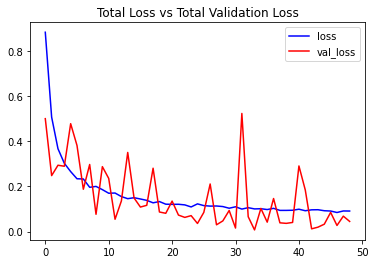

In [19]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

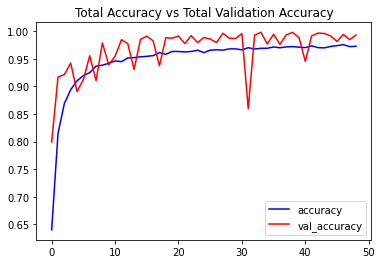

In [20]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [21]:
def download_youtube_videos(youtube_video_url, output_directory):
        
    video = pafy.new(youtube_video_url)
    video_best = video.getbest()
    output_file_path = f'{output_directory}/{video.title}.mp4'
    video_best.download(filepath = output_file_path, quiet = True)
    return video.title

In [22]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
    while True:
    
        status, frame = video_reader.read()
        if not status:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
        if len(predicted_labels_probabilities_deque) == window_size:
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
            predicted_class_name = classes_list[predicted_label]
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()

In [23]:
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [24]:
window_size = 1
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
VideoFileClip(output_video_file_path).ipython_display(width = 700)

100%|██████████| 866/866 [00:01<00:00, 729.79it/s]
